In [1]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

In [2]:
pip install numpy matplotlib torch==2.0.0+cu117 torchvision==0.15.0+cu117 torchaudio==2.0.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import ipywidgets as widgets

In [5]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
DATA_DIR = 'animefaces256cleaner'
print(os.listdir(DATA_DIR))

['images']


In [7]:
print(os.listdir(DATA_DIR+'/images')[:10])

['10004131_result.jpg', '10006043_result.jpg', '10009741_result.jpg', '10010892_result.jpg', '10011231_result.jpg', '10012511_result.jpg', '10012639_result.jpg', '10013048_result.jpg', '10014205_result.jpg', '10014881_result.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=5, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

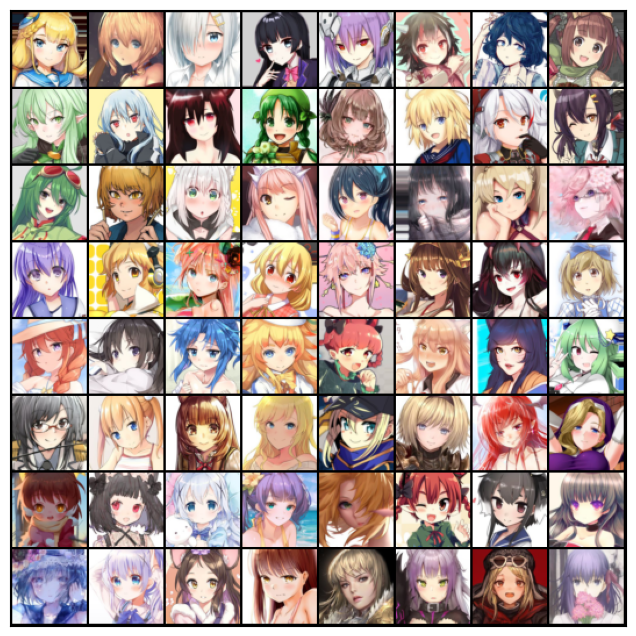

In [14]:
show_batch(train_dl)

In [15]:
#!pip install jovian --upgrade --quiet

In [16]:
#import jovian

In [17]:
#jovian.commit(project=project_name, environment=None)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [19]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
import torch.nn as nn

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 128

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


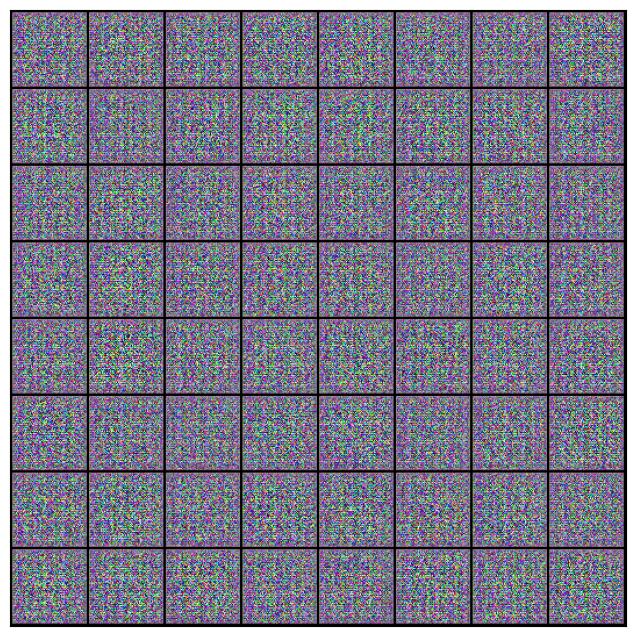

In [26]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    # real_preds = discriminator(real_images)
    # real_targets = torch.ones(real_images.size(0), 1, device=device)
    # real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # real_score = torch.mean(real_preds).item()
    real_preds = discriminator(real_images)
    real_targets = torch.ones_like(real_preds, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [33]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


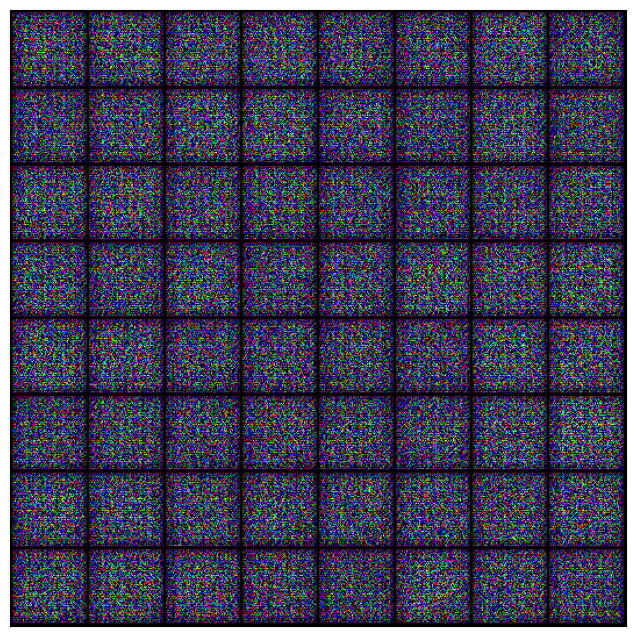

In [34]:
save_samples(0, fixed_latent)

In [35]:
#jovian.commit(project=project_name, environment=None)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [38]:
lr = 0.0002
epochs = 300

In [39]:
#jovian.reset()
#jovian.log_hyperparams(lr=lr, epochs=epochs)

In [40]:
history = fit(epochs, lr)

  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 3.9318, loss_d: 0.4430, real_score: 0.7508, fake_score: 0.0990
Saving generated-images-0001.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 3.9039, loss_d: 0.5274, real_score: 0.7253, fake_score: 0.1431
Saving generated-images-0002.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 3.8907, loss_d: 0.2762, real_score: 0.8254, fake_score: 0.0635
Saving generated-images-0003.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.5936, loss_d: 0.6164, real_score: 0.6030, fake_score: 0.0203
Saving generated-images-0004.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 2.9210, loss_d: 0.1946, real_score: 0.9571, fake_score: 0.1132
Saving generated-images-0005.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 2.8604, loss_d: 0.2109, real_score: 0.9110, fake_score: 0.1015
Saving generated-images-0006.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 3.8310, loss_d: 0.1130, real_score: 0.9596, fake_score: 0.0645
Saving generated-images-0007.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 4.5363, loss_d: 0.1216, real_score: 0.9654, fake_score: 0.0778
Saving generated-images-0008.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 0.9994, loss_d: 1.0516, real_score: 0.4181, fake_score: 0.0009
Saving generated-images-0009.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 6.4483, loss_d: 0.7092, real_score: 0.9490, fake_score: 0.4164
Saving generated-images-0010.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 3.6378, loss_d: 0.2504, real_score: 0.8890, fake_score: 0.1045
Saving generated-images-0011.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 3.1889, loss_d: 0.1652, real_score: 0.9003, fake_score: 0.0436
Saving generated-images-0012.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 4.5423, loss_d: 0.0679, real_score: 0.9757, fake_score: 0.0411
Saving generated-images-0013.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 3.3132, loss_d: 0.2485, real_score: 0.8649, fake_score: 0.0815
Saving generated-images-0014.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 2.3984, loss_d: 0.2401, real_score: 0.8375, fake_score: 0.0230
Saving generated-images-0015.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 0.5849, loss_d: 3.4101, real_score: 0.0715, fake_score: 0.0002
Saving generated-images-0016.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 4.5086, loss_d: 0.0762, real_score: 0.9535, fake_score: 0.0261
Saving generated-images-0017.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 2.0684, loss_d: 0.2798, real_score: 0.8046, fake_score: 0.0200
Saving generated-images-0018.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 6.2198, loss_d: 0.3619, real_score: 0.9901, fake_score: 0.2408
Saving generated-images-0019.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 4.4907, loss_d: 0.1689, real_score: 0.9601, fake_score: 0.1077
Saving generated-images-0020.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 6.1416, loss_d: 0.0472, real_score: 0.9690, fake_score: 0.0137
Saving generated-images-0021.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 5.4545, loss_d: 0.0424, real_score: 0.9862, fake_score: 0.0272
Saving generated-images-0022.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 5.2739, loss_d: 0.1990, real_score: 0.8527, fake_score: 0.0107
Saving generated-images-0023.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 4.3922, loss_d: 0.0811, real_score: 0.9601, fake_score: 0.0364
Saving generated-images-0024.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 5.6456, loss_d: 0.1033, real_score: 0.9753, fake_score: 0.0671
Saving generated-images-0025.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 4.9613, loss_d: 0.2458, real_score: 0.9766, fake_score: 0.1728
Saving generated-images-0026.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 6.2959, loss_d: 0.3116, real_score: 0.7915, fake_score: 0.0088
Saving generated-images-0027.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 4.4170, loss_d: 0.0454, real_score: 0.9770, fake_score: 0.0205
Saving generated-images-0028.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 6.3307, loss_d: 4.8975, real_score: 0.9991, fake_score: 0.9511
Saving generated-images-0029.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 3.6032, loss_d: 0.1756, real_score: 0.8689, fake_score: 0.0111
Saving generated-images-0030.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 4.8774, loss_d: 0.0531, real_score: 0.9754, fake_score: 0.0236
Saving generated-images-0031.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 4.5498, loss_d: 0.1099, real_score: 0.9092, fake_score: 0.0070
Saving generated-images-0032.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 5.0513, loss_d: 0.0907, real_score: 0.9691, fake_score: 0.0483
Saving generated-images-0033.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 5.5929, loss_d: 0.0127, real_score: 0.9953, fake_score: 0.0077
Saving generated-images-0034.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 6.8325, loss_d: 0.0582, real_score: 0.9922, fake_score: 0.0445
Saving generated-images-0035.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 4.3616, loss_d: 0.0789, real_score: 0.9443, fake_score: 0.0145
Saving generated-images-0036.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 4.6805, loss_d: 0.0951, real_score: 0.9357, fake_score: 0.0191
Saving generated-images-0037.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 3.6082, loss_d: 0.1150, real_score: 0.9186, fake_score: 0.0151
Saving generated-images-0038.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 5.8041, loss_d: 0.0532, real_score: 0.9808, fake_score: 0.0282
Saving generated-images-0039.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 3.4792, loss_d: 0.0666, real_score: 0.9596, fake_score: 0.0232
Saving generated-images-0040.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 5.8676, loss_d: 0.0563, real_score: 0.9597, fake_score: 0.0139
Saving generated-images-0041.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 4.3772, loss_d: 0.0730, real_score: 0.9440, fake_score: 0.0127
Saving generated-images-0042.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 6.0808, loss_d: 0.1888, real_score: 0.8678, fake_score: 0.0234
Saving generated-images-0043.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 5.1722, loss_d: 0.0571, real_score: 0.9633, fake_score: 0.0158
Saving generated-images-0044.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 4.5543, loss_d: 0.0398, real_score: 0.9905, fake_score: 0.0273
Saving generated-images-0045.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 5.9965, loss_d: 0.0299, real_score: 0.9774, fake_score: 0.0057
Saving generated-images-0046.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 6.2039, loss_d: 0.0182, real_score: 0.9878, fake_score: 0.0055
Saving generated-images-0047.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 3.4321, loss_d: 0.1187, real_score: 0.9301, fake_score: 0.0263
Saving generated-images-0048.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 6.5587, loss_d: 0.0290, real_score: 0.9887, fake_score: 0.0165
Saving generated-images-0049.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 5.4581, loss_d: 0.0473, real_score: 0.9727, fake_score: 0.0173
Saving generated-images-0050.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 5.7713, loss_d: 0.0325, real_score: 0.9869, fake_score: 0.0184
Saving generated-images-0051.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [52/300], loss_g: 5.9387, loss_d: 0.0422, real_score: 0.9900, fake_score: 0.0291
Saving generated-images-0052.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [53/300], loss_g: 5.6978, loss_d: 0.0641, real_score: 0.9640, fake_score: 0.0227
Saving generated-images-0053.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [54/300], loss_g: 4.1889, loss_d: 0.1017, real_score: 0.9175, fake_score: 0.0084
Saving generated-images-0054.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [55/300], loss_g: 5.7256, loss_d: 0.0324, real_score: 0.9864, fake_score: 0.0179
Saving generated-images-0055.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [56/300], loss_g: 5.3454, loss_d: 0.0326, real_score: 0.9862, fake_score: 0.0174
Saving generated-images-0056.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [57/300], loss_g: 5.1055, loss_d: 0.0416, real_score: 0.9959, fake_score: 0.0347
Saving generated-images-0057.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [58/300], loss_g: 2.2085, loss_d: 0.1960, real_score: 0.8505, fake_score: 0.0088
Saving generated-images-0058.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [59/300], loss_g: 4.6539, loss_d: 0.0644, real_score: 0.9570, fake_score: 0.0188
Saving generated-images-0059.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [60/300], loss_g: 4.5562, loss_d: 0.1277, real_score: 0.9631, fake_score: 0.0710
Saving generated-images-0060.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [61/300], loss_g: 5.7613, loss_d: 0.0347, real_score: 0.9834, fake_score: 0.0160
Saving generated-images-0061.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [62/300], loss_g: 6.6667, loss_d: 0.0291, real_score: 0.9763, fake_score: 0.0041
Saving generated-images-0062.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [63/300], loss_g: 1.9437, loss_d: 1.9017, real_score: 0.2628, fake_score: 0.0026
Saving generated-images-0063.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [64/300], loss_g: 4.2326, loss_d: 0.1380, real_score: 0.9732, fake_score: 0.0922
Saving generated-images-0064.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [65/300], loss_g: 6.7027, loss_d: 0.0154, real_score: 0.9898, fake_score: 0.0049
Saving generated-images-0065.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [66/300], loss_g: 6.1522, loss_d: 0.0475, real_score: 0.9625, fake_score: 0.0043
Saving generated-images-0066.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [67/300], loss_g: 4.7919, loss_d: 0.0435, real_score: 0.9697, fake_score: 0.0097
Saving generated-images-0067.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [68/300], loss_g: 5.9435, loss_d: 0.1143, real_score: 0.9733, fake_score: 0.0688
Saving generated-images-0068.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [69/300], loss_g: 6.6171, loss_d: 0.0882, real_score: 0.9831, fake_score: 0.0553
Saving generated-images-0069.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [70/300], loss_g: 6.5920, loss_d: 0.0858, real_score: 0.9402, fake_score: 0.0113
Saving generated-images-0070.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [71/300], loss_g: 3.2738, loss_d: 0.2933, real_score: 0.8165, fake_score: 0.0256
Saving generated-images-0071.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [72/300], loss_g: 7.1770, loss_d: 0.0381, real_score: 0.9812, fake_score: 0.0174
Saving generated-images-0072.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [73/300], loss_g: 5.7470, loss_d: 0.0687, real_score: 0.9470, fake_score: 0.0069
Saving generated-images-0073.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [74/300], loss_g: 3.7509, loss_d: 0.2105, real_score: 0.9196, fake_score: 0.0591
Saving generated-images-0074.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [75/300], loss_g: 6.2484, loss_d: 0.0721, real_score: 0.9574, fake_score: 0.0239
Saving generated-images-0075.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [76/300], loss_g: 7.1050, loss_d: 0.0499, real_score: 0.9918, fake_score: 0.0349
Saving generated-images-0076.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [77/300], loss_g: 7.2094, loss_d: 0.0316, real_score: 0.9964, fake_score: 0.0264
Saving generated-images-0077.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [78/300], loss_g: 5.2273, loss_d: 0.0483, real_score: 0.9645, fake_score: 0.0095
Saving generated-images-0078.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [79/300], loss_g: 7.8822, loss_d: 0.2003, real_score: 0.9916, fake_score: 0.1091
Saving generated-images-0079.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [80/300], loss_g: 6.7712, loss_d: 0.0106, real_score: 0.9926, fake_score: 0.0031
Saving generated-images-0080.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [81/300], loss_g: 5.5242, loss_d: 0.0271, real_score: 0.9826, fake_score: 0.0087
Saving generated-images-0081.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [82/300], loss_g: 1.6439, loss_d: 0.4247, real_score: 0.7323, fake_score: 0.0138
Saving generated-images-0082.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [83/300], loss_g: 6.2985, loss_d: 0.1099, real_score: 0.9938, fake_score: 0.0775
Saving generated-images-0083.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [84/300], loss_g: 5.2782, loss_d: 0.0448, real_score: 0.9681, fake_score: 0.0097
Saving generated-images-0084.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [85/300], loss_g: 5.4299, loss_d: 0.1017, real_score: 0.9742, fake_score: 0.0613
Saving generated-images-0085.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [86/300], loss_g: 7.8459, loss_d: 0.0140, real_score: 0.9948, fake_score: 0.0086
Saving generated-images-0086.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [87/300], loss_g: 5.4726, loss_d: 0.0527, real_score: 0.9760, fake_score: 0.0232
Saving generated-images-0087.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [88/300], loss_g: 6.3085, loss_d: 0.1183, real_score: 0.9964, fake_score: 0.0950
Saving generated-images-0088.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [89/300], loss_g: 5.7062, loss_d: 0.0222, real_score: 0.9951, fake_score: 0.0161
Saving generated-images-0089.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [90/300], loss_g: 7.6808, loss_d: 0.0549, real_score: 0.9913, fake_score: 0.0392
Saving generated-images-0090.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [91/300], loss_g: 8.8735, loss_d: 0.0312, real_score: 0.9901, fake_score: 0.0199
Saving generated-images-0091.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [92/300], loss_g: 6.1575, loss_d: 0.0389, real_score: 0.9895, fake_score: 0.0257
Saving generated-images-0092.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [93/300], loss_g: 4.9214, loss_d: 0.0608, real_score: 0.9670, fake_score: 0.0238
Saving generated-images-0093.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [94/300], loss_g: 6.6733, loss_d: 0.0224, real_score: 0.9977, fake_score: 0.0171
Saving generated-images-0094.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [95/300], loss_g: 6.7011, loss_d: 0.0323, real_score: 0.9928, fake_score: 0.0222
Saving generated-images-0095.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [96/300], loss_g: 5.9950, loss_d: 0.0098, real_score: 0.9978, fake_score: 0.0074
Saving generated-images-0096.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [97/300], loss_g: 4.9808, loss_d: 0.0424, real_score: 0.9972, fake_score: 0.0354
Saving generated-images-0097.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [98/300], loss_g: 6.5298, loss_d: 0.0550, real_score: 0.9892, fake_score: 0.0345
Saving generated-images-0098.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [99/300], loss_g: 4.8001, loss_d: 0.1957, real_score: 0.9227, fake_score: 0.0819
Saving generated-images-0099.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [100/300], loss_g: 6.9160, loss_d: 0.0655, real_score: 0.9787, fake_score: 0.0381
Saving generated-images-0100.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [101/300], loss_g: 9.3104, loss_d: 0.0184, real_score: 0.9857, fake_score: 0.0022
Saving generated-images-0101.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [102/300], loss_g: 2.5345, loss_d: 0.5078, real_score: 0.7221, fake_score: 0.0348
Saving generated-images-0102.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [103/300], loss_g: 6.9133, loss_d: 0.0191, real_score: 0.9988, fake_score: 0.0165
Saving generated-images-0103.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [104/300], loss_g: 6.5146, loss_d: 0.0190, real_score: 0.9878, fake_score: 0.0061
Saving generated-images-0104.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [105/300], loss_g: 6.5123, loss_d: 0.0309, real_score: 0.9968, fake_score: 0.0255
Saving generated-images-0105.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [106/300], loss_g: 7.4229, loss_d: 0.0472, real_score: 0.9931, fake_score: 0.0318
Saving generated-images-0106.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [107/300], loss_g: 7.9164, loss_d: 15.3999, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0107.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [108/300], loss_g: 4.7002, loss_d: 0.1226, real_score: 0.9578, fake_score: 0.0581
Saving generated-images-0108.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [109/300], loss_g: 7.2849, loss_d: 0.0225, real_score: 0.9885, fake_score: 0.0093
Saving generated-images-0109.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [110/300], loss_g: 4.1791, loss_d: 0.1364, real_score: 0.9083, fake_score: 0.0030
Saving generated-images-0110.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [111/300], loss_g: 5.0581, loss_d: 15.9342, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0111.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [112/300], loss_g: 6.5828, loss_d: 0.0246, real_score: 0.9928, fake_score: 0.0148
Saving generated-images-0112.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [113/300], loss_g: 6.3553, loss_d: 0.0280, real_score: 0.9820, fake_score: 0.0092
Saving generated-images-0113.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [114/300], loss_g: 5.3406, loss_d: 0.0413, real_score: 0.9747, fake_score: 0.0131
Saving generated-images-0114.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [115/300], loss_g: 7.6609, loss_d: 0.0051, real_score: 0.9976, fake_score: 0.0026
Saving generated-images-0115.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [116/300], loss_g: 4.3642, loss_d: 0.1979, real_score: 0.9341, fake_score: 0.0902
Saving generated-images-0116.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [117/300], loss_g: 6.3560, loss_d: 0.0284, real_score: 0.9973, fake_score: 0.0241
Saving generated-images-0117.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [118/300], loss_g: 4.7322, loss_d: 0.0935, real_score: 0.9653, fake_score: 0.0471
Saving generated-images-0118.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [119/300], loss_g: 7.0074, loss_d: 0.0082, real_score: 0.9967, fake_score: 0.0048
Saving generated-images-0119.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [120/300], loss_g: 4.9957, loss_d: 0.1277, real_score: 0.9360, fake_score: 0.0464
Saving generated-images-0120.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [121/300], loss_g: 5.5102, loss_d: 0.0570, real_score: 0.9788, fake_score: 0.0239
Saving generated-images-0121.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [122/300], loss_g: 5.9928, loss_d: 0.0337, real_score: 0.9764, fake_score: 0.0087
Saving generated-images-0122.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [123/300], loss_g: 6.5780, loss_d: 0.0178, real_score: 0.9890, fake_score: 0.0063
Saving generated-images-0123.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [124/300], loss_g: 8.3191, loss_d: 0.1793, real_score: 0.9442, fake_score: 0.0392
Saving generated-images-0124.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [125/300], loss_g: 6.0859, loss_d: 0.0209, real_score: 0.9825, fake_score: 0.0025
Saving generated-images-0125.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [126/300], loss_g: 4.8804, loss_d: 0.0616, real_score: 0.9595, fake_score: 0.0157
Saving generated-images-0126.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [127/300], loss_g: 5.4299, loss_d: 0.3011, real_score: 0.9701, fake_score: 0.1557
Saving generated-images-0127.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [128/300], loss_g: 7.5669, loss_d: 0.0237, real_score: 0.9979, fake_score: 0.0183
Saving generated-images-0128.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [129/300], loss_g: 7.5603, loss_d: 0.0586, real_score: 0.9538, fake_score: 0.0065
Saving generated-images-0129.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [130/300], loss_g: 9.6071, loss_d: 0.0093, real_score: 0.9986, fake_score: 0.0078
Saving generated-images-0130.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [131/300], loss_g: 6.5808, loss_d: 0.0109, real_score: 0.9989, fake_score: 0.0094
Saving generated-images-0131.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [132/300], loss_g: 4.5523, loss_d: 0.0568, real_score: 0.9843, fake_score: 0.0375
Saving generated-images-0132.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [133/300], loss_g: 6.6340, loss_d: 0.0097, real_score: 0.9975, fake_score: 0.0070
Saving generated-images-0133.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [134/300], loss_g: 6.8044, loss_d: 0.0287, real_score: 0.9835, fake_score: 0.0102
Saving generated-images-0134.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [135/300], loss_g: 6.9818, loss_d: 0.0106, real_score: 0.9978, fake_score: 0.0081
Saving generated-images-0135.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [136/300], loss_g: 2.0052, loss_d: 0.1375, real_score: 0.8915, fake_score: 0.0019
Saving generated-images-0136.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [137/300], loss_g: 5.7876, loss_d: 0.0266, real_score: 0.9817, fake_score: 0.0074
Saving generated-images-0137.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [138/300], loss_g: 2.5329, loss_d: 0.1993, real_score: 0.8735, fake_score: 0.0107
Saving generated-images-0138.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [139/300], loss_g: 6.6007, loss_d: 0.0151, real_score: 0.9949, fake_score: 0.0097
Saving generated-images-0139.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [140/300], loss_g: 5.5353, loss_d: 0.0372, real_score: 0.9934, fake_score: 0.0282
Saving generated-images-0140.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [141/300], loss_g: 6.6297, loss_d: 0.0226, real_score: 0.9810, fake_score: 0.0020
Saving generated-images-0141.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [142/300], loss_g: 6.4436, loss_d: 0.1217, real_score: 0.9221, fake_score: 0.0287
Saving generated-images-0142.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [143/300], loss_g: 6.7020, loss_d: 0.0068, real_score: 0.9974, fake_score: 0.0041
Saving generated-images-0143.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [144/300], loss_g: 3.5160, loss_d: 0.1405, real_score: 0.9024, fake_score: 0.0133
Saving generated-images-0144.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [145/300], loss_g: 7.8018, loss_d: 0.0052, real_score: 0.9988, fake_score: 0.0039
Saving generated-images-0145.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [146/300], loss_g: 0.0000, loss_d: 1.1201, real_score: 0.4608, fake_score: 0.0000
Saving generated-images-0146.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [147/300], loss_g: 6.3880, loss_d: 0.0196, real_score: 0.9956, fake_score: 0.0142
Saving generated-images-0147.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [148/300], loss_g: 8.0298, loss_d: 0.0316, real_score: 0.9876, fake_score: 0.0162
Saving generated-images-0148.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [149/300], loss_g: 5.9894, loss_d: 0.0185, real_score: 0.9915, fake_score: 0.0097
Saving generated-images-0149.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [150/300], loss_g: 9.8286, loss_d: 0.0072, real_score: 0.9980, fake_score: 0.0051
Saving generated-images-0150.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [151/300], loss_g: 5.1817, loss_d: 0.1054, real_score: 0.9462, fake_score: 0.0339
Saving generated-images-0151.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [152/300], loss_g: 6.2562, loss_d: 0.0968, real_score: 0.9893, fake_score: 0.0680
Saving generated-images-0152.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [153/300], loss_g: 6.3171, loss_d: 0.1247, real_score: 0.9474, fake_score: 0.0387
Saving generated-images-0153.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [154/300], loss_g: 6.5964, loss_d: 0.0388, real_score: 0.9777, fake_score: 0.0146
Saving generated-images-0154.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [155/300], loss_g: 8.0884, loss_d: 0.0200, real_score: 0.9840, fake_score: 0.0033
Saving generated-images-0155.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [156/300], loss_g: 6.7407, loss_d: 0.0765, real_score: 0.9962, fake_score: 0.0538
Saving generated-images-0156.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [157/300], loss_g: 7.2538, loss_d: 0.0458, real_score: 0.9998, fake_score: 0.0362
Saving generated-images-0157.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [158/300], loss_g: 6.1377, loss_d: 0.2524, real_score: 1.0000, fake_score: 0.1482
Saving generated-images-0158.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [159/300], loss_g: 7.0233, loss_d: 0.0197, real_score: 0.9995, fake_score: 0.0182
Saving generated-images-0159.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [160/300], loss_g: 8.4590, loss_d: 0.0763, real_score: 0.9987, fake_score: 0.0559
Saving generated-images-0160.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [161/300], loss_g: 7.7043, loss_d: 0.0162, real_score: 0.9934, fake_score: 0.0092
Saving generated-images-0161.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [162/300], loss_g: 7.7512, loss_d: 0.0250, real_score: 0.9923, fake_score: 0.0158
Saving generated-images-0162.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [163/300], loss_g: 5.4567, loss_d: 0.0203, real_score: 0.9851, fake_score: 0.0047
Saving generated-images-0163.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [164/300], loss_g: 6.8821, loss_d: 0.0388, real_score: 0.9966, fake_score: 0.0246
Saving generated-images-0164.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [165/300], loss_g: 5.0917, loss_d: 0.0737, real_score: 0.9496, fake_score: 0.0178
Saving generated-images-0165.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [166/300], loss_g: 1.1476, loss_d: 1.8782, real_score: 0.2873, fake_score: 0.0000
Saving generated-images-0166.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [167/300], loss_g: 6.7120, loss_d: 0.0162, real_score: 0.9895, fake_score: 0.0053
Saving generated-images-0167.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [168/300], loss_g: 5.2292, loss_d: 0.1454, real_score: 0.9267, fake_score: 0.0496
Saving generated-images-0168.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [169/300], loss_g: 7.7693, loss_d: 0.0097, real_score: 0.9973, fake_score: 0.0069
Saving generated-images-0169.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [170/300], loss_g: 7.8123, loss_d: 0.0186, real_score: 0.9942, fake_score: 0.0115
Saving generated-images-0170.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [171/300], loss_g: 4.1361, loss_d: 0.0659, real_score: 0.9507, fake_score: 0.0084
Saving generated-images-0171.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [172/300], loss_g: 6.6692, loss_d: 0.0034, real_score: 0.9976, fake_score: 0.0009
Saving generated-images-0172.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [173/300], loss_g: 6.8500, loss_d: 0.0602, real_score: 0.9872, fake_score: 0.0362
Saving generated-images-0173.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [174/300], loss_g: 6.9892, loss_d: 0.0074, real_score: 0.9990, fake_score: 0.0061
Saving generated-images-0174.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [175/300], loss_g: 0.0502, loss_d: 1.5939, real_score: 0.3802, fake_score: 0.0000
Saving generated-images-0175.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [176/300], loss_g: 8.7411, loss_d: 0.0364, real_score: 0.9984, fake_score: 0.0254
Saving generated-images-0176.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [177/300], loss_g: 5.2851, loss_d: 0.0394, real_score: 0.9708, fake_score: 0.0067
Saving generated-images-0177.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [178/300], loss_g: 0.9319, loss_d: 0.2573, real_score: 0.8475, fake_score: 0.0015
Saving generated-images-0178.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [179/300], loss_g: 19.7237, loss_d: 18.5184, real_score: 1.0000, fake_score: 0.9018
Saving generated-images-0179.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [180/300], loss_g: 6.8390, loss_d: 0.0505, real_score: 0.9599, fake_score: 0.0012
Saving generated-images-0180.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [181/300], loss_g: 6.6141, loss_d: 0.0220, real_score: 0.9914, fake_score: 0.0127
Saving generated-images-0181.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [182/300], loss_g: 5.9014, loss_d: 0.0877, real_score: 0.9689, fake_score: 0.0421
Saving generated-images-0182.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [183/300], loss_g: 6.0209, loss_d: 0.0310, real_score: 0.9747, fake_score: 0.0035
Saving generated-images-0183.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [184/300], loss_g: 6.1745, loss_d: 0.0234, real_score: 0.9993, fake_score: 0.0219
Saving generated-images-0184.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [185/300], loss_g: 8.2413, loss_d: 0.0949, real_score: 0.9325, fake_score: 0.0013
Saving generated-images-0185.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [186/300], loss_g: 7.5818, loss_d: 0.0072, real_score: 0.9963, fake_score: 0.0034
Saving generated-images-0186.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [187/300], loss_g: 5.3604, loss_d: 0.0746, real_score: 0.9630, fake_score: 0.0233
Saving generated-images-0187.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [188/300], loss_g: 11.0585, loss_d: 0.0343, real_score: 0.9694, fake_score: 0.0019
Saving generated-images-0188.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [189/300], loss_g: 9.8180, loss_d: 0.0588, real_score: 0.9503, fake_score: 0.0008
Saving generated-images-0189.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [190/300], loss_g: 6.2997, loss_d: 0.0078, real_score: 0.9934, fake_score: 0.0010
Saving generated-images-0190.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [191/300], loss_g: 6.2872, loss_d: 0.0149, real_score: 0.9977, fake_score: 0.0119
Saving generated-images-0191.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [192/300], loss_g: 5.9705, loss_d: 0.0476, real_score: 0.9962, fake_score: 0.0379
Saving generated-images-0192.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [193/300], loss_g: 3.9702, loss_d: 0.2185, real_score: 0.8761, fake_score: 0.0290
Saving generated-images-0193.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [194/300], loss_g: 5.9578, loss_d: 0.1315, real_score: 0.9024, fake_score: 0.0001
Saving generated-images-0194.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [195/300], loss_g: 7.5414, loss_d: 0.0372, real_score: 0.9800, fake_score: 0.0139
Saving generated-images-0195.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [196/300], loss_g: 5.4688, loss_d: 0.0971, real_score: 0.9471, fake_score: 0.0249
Saving generated-images-0196.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [197/300], loss_g: 1.7508, loss_d: 0.1418, real_score: 0.8959, fake_score: 0.0036
Saving generated-images-0197.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [198/300], loss_g: 6.0410, loss_d: 0.0837, real_score: 0.9788, fake_score: 0.0523
Saving generated-images-0198.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [199/300], loss_g: 7.4790, loss_d: 0.0513, real_score: 0.9863, fake_score: 0.0314
Saving generated-images-0199.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [200/300], loss_g: 5.4818, loss_d: 0.1118, real_score: 0.9256, fake_score: 0.0052
Saving generated-images-0200.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [201/300], loss_g: 7.4085, loss_d: 0.0149, real_score: 0.9898, fake_score: 0.0044
Saving generated-images-0201.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [202/300], loss_g: 2.2647, loss_d: 0.2243, real_score: 0.8538, fake_score: 0.0029
Saving generated-images-0202.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [203/300], loss_g: 8.1001, loss_d: 0.0176, real_score: 0.9852, fake_score: 0.0022
Saving generated-images-0203.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [204/300], loss_g: 1.4815, loss_d: 0.2027, real_score: 0.8541, fake_score: 0.0080
Saving generated-images-0204.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [205/300], loss_g: 7.2640, loss_d: 0.0158, real_score: 0.9905, fake_score: 0.0059
Saving generated-images-0205.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [206/300], loss_g: 5.4659, loss_d: 0.0414, real_score: 0.9735, fake_score: 0.0101
Saving generated-images-0206.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [207/300], loss_g: 8.2611, loss_d: 0.0125, real_score: 0.9990, fake_score: 0.0108
Saving generated-images-0207.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [208/300], loss_g: 5.4622, loss_d: 0.0331, real_score: 0.9914, fake_score: 0.0228
Saving generated-images-0208.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [209/300], loss_g: 6.5900, loss_d: 0.0423, real_score: 0.9765, fake_score: 0.0169
Saving generated-images-0209.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [210/300], loss_g: 8.9543, loss_d: 0.0266, real_score: 0.9992, fake_score: 0.0224
Saving generated-images-0210.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [211/300], loss_g: 10.1898, loss_d: 0.0234, real_score: 0.9932, fake_score: 0.0109
Saving generated-images-0211.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [212/300], loss_g: 6.2990, loss_d: 0.0416, real_score: 0.9753, fake_score: 0.0139
Saving generated-images-0212.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [213/300], loss_g: 9.0420, loss_d: 0.0055, real_score: 0.9983, fake_score: 0.0037
Saving generated-images-0213.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [214/300], loss_g: 6.9972, loss_d: 0.0116, real_score: 0.9969, fake_score: 0.0080
Saving generated-images-0214.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [215/300], loss_g: 6.3900, loss_d: 0.0275, real_score: 0.9893, fake_score: 0.0159
Saving generated-images-0215.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [216/300], loss_g: 7.4072, loss_d: 0.0355, real_score: 0.9923, fake_score: 0.0255
Saving generated-images-0216.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [217/300], loss_g: 5.7955, loss_d: 0.0468, real_score: 0.9845, fake_score: 0.0273
Saving generated-images-0217.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [218/300], loss_g: 6.1036, loss_d: 0.0481, real_score: 0.9659, fake_score: 0.0077
Saving generated-images-0218.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [219/300], loss_g: 7.0993, loss_d: 0.0137, real_score: 0.9896, fake_score: 0.0024
Saving generated-images-0219.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [220/300], loss_g: 7.9747, loss_d: 0.0165, real_score: 0.9852, fake_score: 0.0010
Saving generated-images-0220.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [221/300], loss_g: 5.5321, loss_d: 0.0448, real_score: 0.9851, fake_score: 0.0246
Saving generated-images-0221.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [222/300], loss_g: 7.9172, loss_d: 0.0056, real_score: 0.9980, fake_score: 0.0034
Saving generated-images-0222.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [223/300], loss_g: 8.2269, loss_d: 0.0961, real_score: 0.9980, fake_score: 0.0630
Saving generated-images-0223.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [224/300], loss_g: 10.2284, loss_d: 0.0729, real_score: 0.9999, fake_score: 0.0572
Saving generated-images-0224.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [225/300], loss_g: 5.0324, loss_d: 0.0432, real_score: 0.9734, fake_score: 0.0118
Saving generated-images-0225.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [226/300], loss_g: 12.2370, loss_d: 0.0244, real_score: 0.9769, fake_score: 0.0003
Saving generated-images-0226.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [227/300], loss_g: 8.9587, loss_d: 0.0102, real_score: 0.9952, fake_score: 0.0052
Saving generated-images-0227.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [228/300], loss_g: 5.1717, loss_d: 0.0351, real_score: 0.9916, fake_score: 0.0243
Saving generated-images-0228.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [229/300], loss_g: 7.8545, loss_d: 0.0092, real_score: 0.9941, fake_score: 0.0029
Saving generated-images-0229.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [230/300], loss_g: 5.6496, loss_d: 0.2400, real_score: 0.8832, fake_score: 0.0305
Saving generated-images-0230.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [231/300], loss_g: 5.8609, loss_d: 0.0543, real_score: 0.9646, fake_score: 0.0107
Saving generated-images-0231.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [232/300], loss_g: 9.5359, loss_d: 0.0872, real_score: 0.9992, fake_score: 0.0646
Saving generated-images-0232.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [233/300], loss_g: 9.6587, loss_d: 0.0834, real_score: 0.9447, fake_score: 0.0038
Saving generated-images-0233.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [234/300], loss_g: 8.0226, loss_d: 0.0266, real_score: 0.9870, fake_score: 0.0101
Saving generated-images-0234.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [235/300], loss_g: 2.2924, loss_d: 0.1457, real_score: 0.8928, fake_score: 0.0035
Saving generated-images-0235.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [236/300], loss_g: 8.0374, loss_d: 0.0440, real_score: 0.9621, fake_score: 0.0025
Saving generated-images-0236.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [237/300], loss_g: 12.3307, loss_d: 0.0199, real_score: 0.9949, fake_score: 0.0134
Saving generated-images-0237.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [238/300], loss_g: 8.4050, loss_d: 0.0267, real_score: 0.9808, fake_score: 0.0042
Saving generated-images-0238.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [239/300], loss_g: 9.2087, loss_d: 0.0848, real_score: 0.9320, fake_score: 0.0006
Saving generated-images-0239.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [240/300], loss_g: 5.8253, loss_d: 0.0170, real_score: 0.9906, fake_score: 0.0067
Saving generated-images-0240.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [241/300], loss_g: 8.1238, loss_d: 0.0093, real_score: 0.9984, fake_score: 0.0075
Saving generated-images-0241.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [242/300], loss_g: 4.5649, loss_d: 0.0586, real_score: 0.9591, fake_score: 0.0122
Saving generated-images-0242.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [243/300], loss_g: 6.8204, loss_d: 0.0086, real_score: 0.9949, fake_score: 0.0032
Saving generated-images-0243.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [244/300], loss_g: 6.7170, loss_d: 0.0197, real_score: 0.9969, fake_score: 0.0144
Saving generated-images-0244.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [245/300], loss_g: 6.5305, loss_d: 0.0272, real_score: 0.9907, fake_score: 0.0153
Saving generated-images-0245.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [246/300], loss_g: 7.0951, loss_d: 0.0387, real_score: 0.9927, fake_score: 0.0285
Saving generated-images-0246.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [247/300], loss_g: 9.0582, loss_d: 0.0120, real_score: 0.9991, fake_score: 0.0096
Saving generated-images-0247.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [248/300], loss_g: 6.7818, loss_d: 0.0592, real_score: 0.9785, fake_score: 0.0331
Saving generated-images-0248.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [249/300], loss_g: 9.1655, loss_d: 0.0388, real_score: 0.9957, fake_score: 0.0314
Saving generated-images-0249.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [250/300], loss_g: 7.7886, loss_d: 0.0723, real_score: 0.9940, fake_score: 0.0419
Saving generated-images-0250.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [251/300], loss_g: 5.0083, loss_d: 0.1400, real_score: 0.9403, fake_score: 0.0441
Saving generated-images-0251.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [252/300], loss_g: 6.3544, loss_d: 0.0489, real_score: 0.9735, fake_score: 0.0113
Saving generated-images-0252.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [253/300], loss_g: 7.9005, loss_d: 0.0240, real_score: 0.9998, fake_score: 0.0217
Saving generated-images-0253.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [254/300], loss_g: 13.1850, loss_d: 0.0104, real_score: 0.9939, fake_score: 0.0038
Saving generated-images-0254.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [255/300], loss_g: 6.9359, loss_d: 0.0180, real_score: 0.9948, fake_score: 0.0121
Saving generated-images-0255.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [256/300], loss_g: 5.5466, loss_d: 0.0477, real_score: 0.9991, fake_score: 0.0399
Saving generated-images-0256.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [257/300], loss_g: 6.8252, loss_d: 0.0509, real_score: 0.9795, fake_score: 0.0224
Saving generated-images-0257.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [258/300], loss_g: 7.0738, loss_d: 0.0300, real_score: 0.9803, fake_score: 0.0063
Saving generated-images-0258.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [259/300], loss_g: 5.0653, loss_d: 0.0685, real_score: 0.9839, fake_score: 0.0458
Saving generated-images-0259.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [260/300], loss_g: 4.0602, loss_d: 0.1155, real_score: 0.9183, fake_score: 0.0067
Saving generated-images-0260.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [261/300], loss_g: 10.3809, loss_d: 0.0049, real_score: 0.9965, fake_score: 0.0014
Saving generated-images-0261.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [262/300], loss_g: 8.2167, loss_d: 0.0179, real_score: 0.9921, fake_score: 0.0090
Saving generated-images-0262.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [263/300], loss_g: 6.6435, loss_d: 0.0207, real_score: 0.9877, fake_score: 0.0072
Saving generated-images-0263.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [264/300], loss_g: 6.7924, loss_d: 0.1078, real_score: 0.9345, fake_score: 0.0234
Saving generated-images-0264.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [265/300], loss_g: 9.9024, loss_d: 0.0064, real_score: 0.9985, fake_score: 0.0047
Saving generated-images-0265.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [266/300], loss_g: 8.9506, loss_d: 0.0790, real_score: 0.9669, fake_score: 0.0301
Saving generated-images-0266.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [267/300], loss_g: 4.1957, loss_d: 0.0852, real_score: 0.9704, fake_score: 0.0441
Saving generated-images-0267.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [268/300], loss_g: 5.3737, loss_d: 0.1231, real_score: 0.9495, fake_score: 0.0283
Saving generated-images-0268.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [269/300], loss_g: 6.7998, loss_d: 0.0210, real_score: 0.9975, fake_score: 0.0176
Saving generated-images-0269.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [270/300], loss_g: 7.7220, loss_d: 0.1436, real_score: 0.9936, fake_score: 0.0878
Saving generated-images-0270.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [271/300], loss_g: 9.4776, loss_d: 0.0054, real_score: 0.9986, fake_score: 0.0039
Saving generated-images-0271.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [272/300], loss_g: 5.1892, loss_d: 0.0450, real_score: 0.9623, fake_score: 0.0024
Saving generated-images-0272.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [273/300], loss_g: 10.4812, loss_d: 0.0095, real_score: 0.9919, fake_score: 0.0010
Saving generated-images-0273.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [274/300], loss_g: 4.7200, loss_d: 0.0882, real_score: 0.9665, fake_score: 0.0404
Saving generated-images-0274.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [275/300], loss_g: 9.2583, loss_d: 0.0393, real_score: 0.9853, fake_score: 0.0204
Saving generated-images-0275.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [276/300], loss_g: 11.6336, loss_d: 0.0048, real_score: 0.9993, fake_score: 0.0038
Saving generated-images-0276.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [277/300], loss_g: 10.3836, loss_d: 0.0142, real_score: 0.9969, fake_score: 0.0108
Saving generated-images-0277.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [278/300], loss_g: 7.2419, loss_d: 0.0174, real_score: 0.9947, fake_score: 0.0107
Saving generated-images-0278.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [279/300], loss_g: 11.1852, loss_d: 0.0294, real_score: 0.9835, fake_score: 0.0104
Saving generated-images-0279.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [280/300], loss_g: 5.9873, loss_d: 0.0402, real_score: 0.9923, fake_score: 0.0301
Saving generated-images-0280.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [281/300], loss_g: 7.4778, loss_d: 0.0191, real_score: 0.9967, fake_score: 0.0138
Saving generated-images-0281.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [282/300], loss_g: 7.3459, loss_d: 0.0698, real_score: 0.9512, fake_score: 0.0074
Saving generated-images-0282.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [283/300], loss_g: 10.0237, loss_d: 0.1628, real_score: 0.9903, fake_score: 0.0916
Saving generated-images-0283.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [284/300], loss_g: 7.4663, loss_d: 0.1448, real_score: 0.9787, fake_score: 0.0887
Saving generated-images-0284.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [285/300], loss_g: 6.6560, loss_d: 0.0164, real_score: 0.9933, fake_score: 0.0077
Saving generated-images-0285.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [286/300], loss_g: 6.2357, loss_d: 0.1669, real_score: 0.9999, fake_score: 0.1247
Saving generated-images-0286.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [287/300], loss_g: 3.5483, loss_d: 0.0933, real_score: 0.9252, fake_score: 0.0008
Saving generated-images-0287.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [288/300], loss_g: 5.6742, loss_d: 0.1205, real_score: 0.9447, fake_score: 0.0120
Saving generated-images-0288.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [289/300], loss_g: 5.9629, loss_d: 0.0839, real_score: 0.9338, fake_score: 0.0012
Saving generated-images-0289.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [290/300], loss_g: 8.8794, loss_d: 0.0040, real_score: 0.9981, fake_score: 0.0021
Saving generated-images-0290.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [291/300], loss_g: 8.4201, loss_d: 0.0280, real_score: 0.9955, fake_score: 0.0206
Saving generated-images-0291.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [292/300], loss_g: 11.9589, loss_d: 0.0444, real_score: 0.9964, fake_score: 0.0294
Saving generated-images-0292.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [293/300], loss_g: 8.2588, loss_d: 0.0102, real_score: 0.9914, fake_score: 0.0013
Saving generated-images-0293.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [294/300], loss_g: 7.4213, loss_d: 0.0055, real_score: 0.9983, fake_score: 0.0037
Saving generated-images-0294.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [295/300], loss_g: 6.3015, loss_d: 0.0224, real_score: 0.9959, fake_score: 0.0162
Saving generated-images-0295.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [296/300], loss_g: 6.1901, loss_d: 0.1289, real_score: 0.9721, fake_score: 0.0692
Saving generated-images-0296.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [297/300], loss_g: 7.7316, loss_d: 0.0331, real_score: 0.9991, fake_score: 0.0191
Saving generated-images-0297.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [298/300], loss_g: 7.0230, loss_d: 0.0161, real_score: 0.9877, fake_score: 0.0020
Saving generated-images-0298.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [299/300], loss_g: 8.0985, loss_d: 0.0424, real_score: 0.9838, fake_score: 0.0194
Saving generated-images-0299.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [300/300], loss_g: 6.8437, loss_d: 0.0745, real_score: 0.9609, fake_score: 0.0157
Saving generated-images-0300.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

In [42]:
# jovian.log_metrics(loss_g=losses_g[-1],
#                    loss_d=losses_d[-1],
#                    real_score=real_scores[-1],
#                    fake_score=fake_scores[-1])

Now that we have trained the models, we can save checkpoints.

In [43]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [44]:
from IPython.display import Image

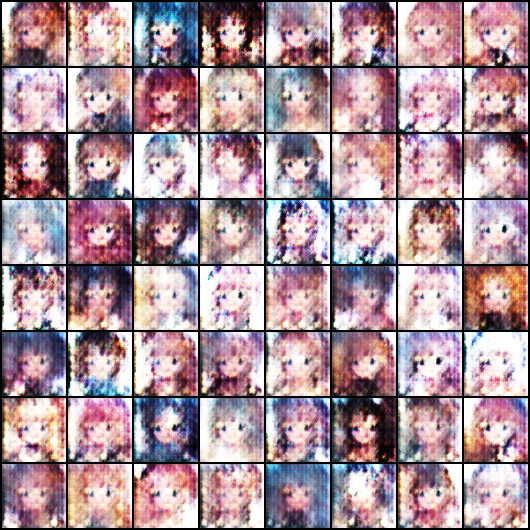

In [45]:
Image('./generated/generated-images-0001.png')

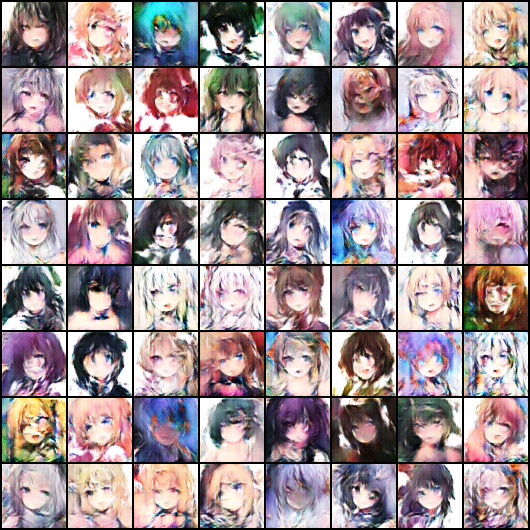

In [46]:
Image('./generated/generated-images-0005.png')

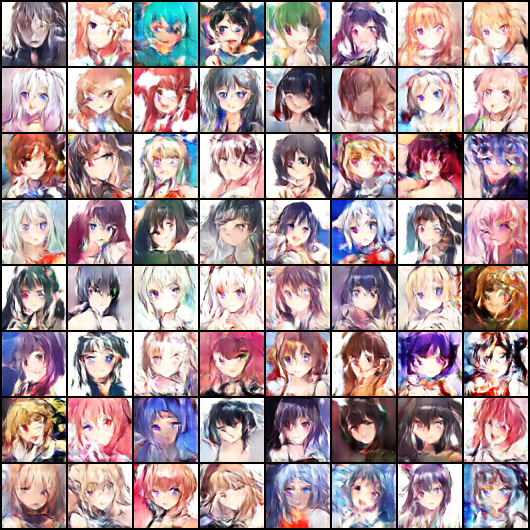

In [47]:
Image('./generated/generated-images-0010.png')

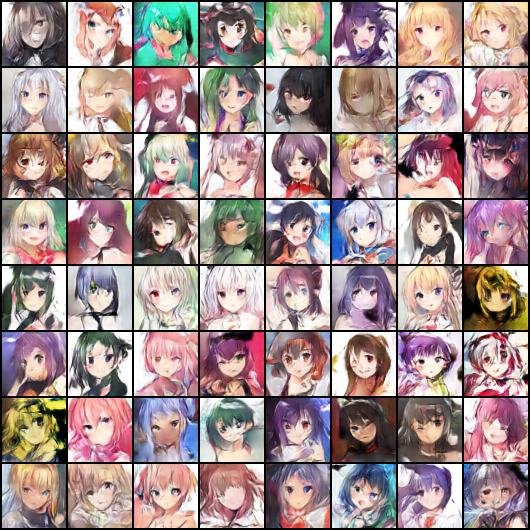

In [48]:
Image('./generated/generated-images-0020.png')

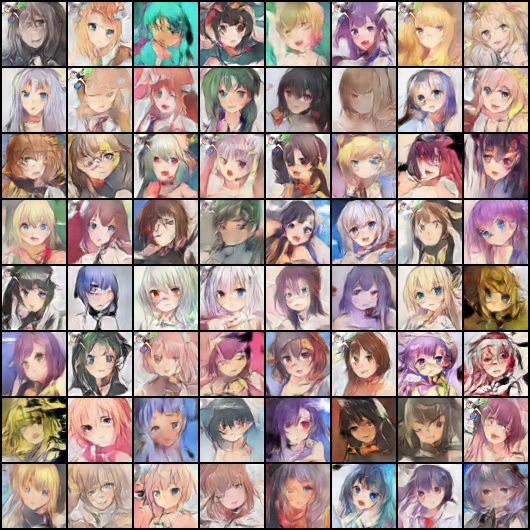

In [49]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [50]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



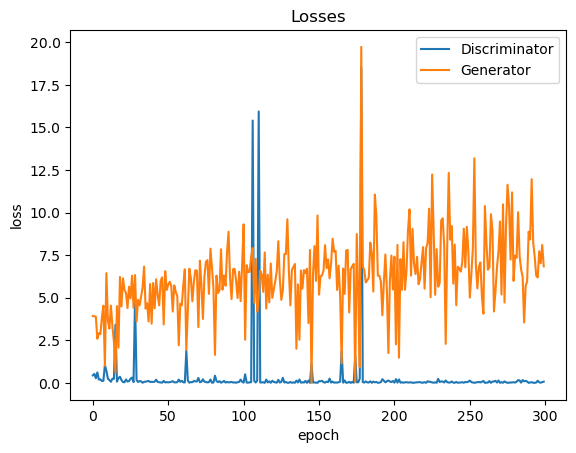

In [51]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

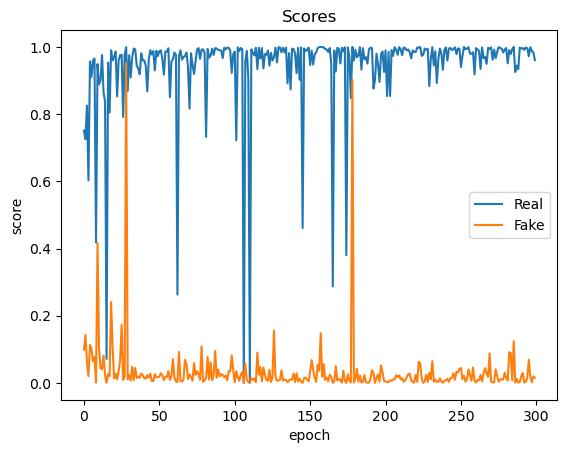

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Save and Commit

We can upload the full snapshot of this experiment to Jovian:
- Jupyter notebook
- Hyperparameters & metrics
- Models weights
- Training video

In [53]:
#import jovian

In [54]:
# jovian.commit(project=project_name,
#               outputs=['G.pth', 'D.pth', 'gans_training.avi'],
#               environment=None)